In [2]:
import geopandas as gpd

df = gpd.read_file('./data/tokyo_west.gpkg')[['rID', 'ftCode', 'type', 'rdCtg', 'rnkWidth', 'geometry']]
df = df[(df['type'] == '通常部') & (df['rnkWidth'] != '3m未満')]

In [3]:
bounds = {
  "_southWest": {
    "lat": 35.68216095848307,
    "lng": 139.67837333827006
  },
  "_northEast": {
    "lat": 35.6978458041904,
    "lng": 139.70841407923686
  }
}
adf = df.cx[bounds['_southWest']['lng']:bounds['_northEast']['lng'], bounds['_southWest']['lat']:bounds['_northEast']['lat']]

In [4]:
from shapely.geometry import Point, LineString

line = [
[
    139.689426,
    35.689673
],
[
    139.697631,
    35.692417
]
]
edge_df = gpd.GeoDataFrame(geometry=[Point(line[0]), Point(line[1])], crs="epsg:6668")
line_df = gpd.GeoDataFrame(geometry=[LineString([line[0], line[1]])], crs="epsg:6668")

In [5]:
nearest_df = gpd.sjoin_nearest(adf, edge_df, distance_col='distance', how='inner')

/Users/suika/Projects/GPTxGIS/codes/scene_analyzer/.venv/lib/python3.10/site-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [6]:
import math

def get_near_edge(p, geom):
    f = lambda p1, p2: math.hypot(p2[0] - p1[0], p2[1] - p1[1])
    hp, tp = geom.coords[0], geom.coords[-1] 
    return hp if f(hp, p) < f(tp, p) else tp

head_row = nearest_df[nearest_df.index_right == 0].sort_values('distance').iloc[0]
head_p = get_near_edge(line[0], head_row.geometry)
tail_row = nearest_df[nearest_df.index_right == 1].sort_values('distance').iloc[0]
tail_p = get_near_edge(line[-1], tail_row.geometry)

In [10]:
import momepy
import networkx as nx
import pandas as pd

G = momepy.gdf_to_nx(adf, approach="primal")
nodes = nx.shortest_path(G, source=head_p, target=tail_p)
path_df = pd.DataFrame([list(G[hn][tn].values())[0] for hn, tn in zip(nodes[:-1], nodes[1:])]).pipe(gpd.GeoDataFrame)

/Users/suika/Projects/GPTxGIS/codes/scene_analyzer/.venv/lib/python3.10/site-packages/momepy/utils.py:252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


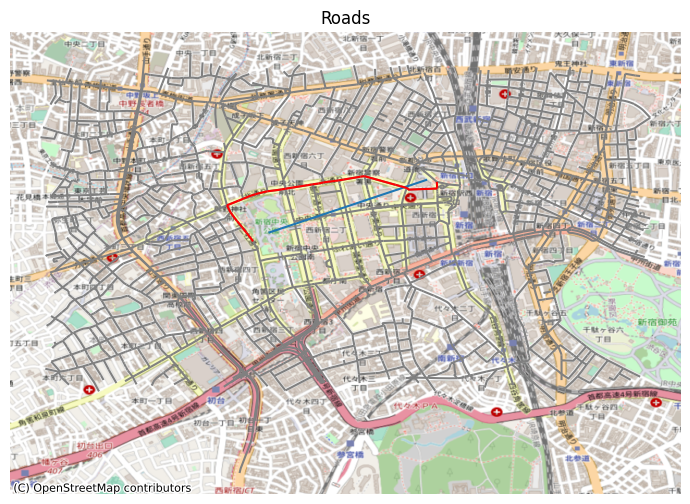

In [83]:
import matplotlib.pyplot as plt
import contextily as cx
# from libpysal import weights

# Plot
f, ax = plt.subplots(1, 1, figsize=(12, 6), sharex=True, sharey=True)
adf.plot(color='gray', ax=ax)
line_df.plot(ax=ax)
path_df.plot(color='red', ax=ax)
ax.set_title("Roads")
ax.axis("off")
cx.add_basemap(ax, crs=adf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)